In [11]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
import random

data1 = loadmat('lab2_1.mat')
data2 = loadmat('lab2_2.mat')
data3 = loadmat('lab2_3.mat')

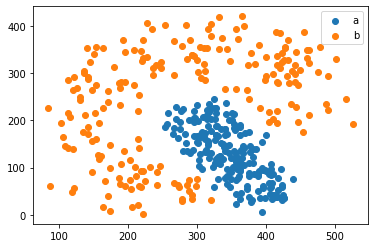

In [2]:
# Plot the data
a = data3['a'].astype(int)
b = data3['b'].astype(int)

plt.scatter(a[:, 0], a[:, 1], label='a')
plt.scatter(b[:, 0], b[:, 1], label='b')
plt.legend()
plt.show()

In [3]:
# Create grid to classify for boundaries
xlims = (100, 500)
ylims = (0, 400)
dx = dy = 1

xx, yy = np.meshgrid(np.arange(*xlims, dx), np.arange(*ylims, dy))

# Create vectors to feed to classifier
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
grid = np.hstack((r1, r2))

In [7]:
def linear_discriminant(x, a, b):
    """
    x is n x 2 matrix of data
    returns n-vector of discriminant values
    """
    disc = (a - b).reshape(1, 2) @ x.T + 0.5 * (b.T @ b - a.T @ a)
    return disc.flatten()

In [8]:
def learn_sequential_classifier(a, b, max_iter=None):
    j = 0
    if max_iter is None:
        max_iter = np.inf
    n_aB = 1
    n_bA = 1

    a_inds = np.ones(a.shape[0]).astype(bool)
    b_inds = np.ones(b.shape[0]).astype(bool)

    G = []
    while (n_aB != 0 or n_bA != 0) and (j < max_iter):
        n_aB = 1
        n_bA = 1
        while n_aB != 0 and n_bA != 0:
            # Select a random point from a and b
            a_j = random.sample(list(a[a_inds, :]), 1)[0]
            b_j = random.sample(list(b[b_inds, :]), 1)[0]

            # Create discriminant using MED with two points
            g = partial(linear_discriminant, a=a_j, b=b_j)

            # Classify points in A and B
            a_cls = (g(a[a_inds]) > 0)  # 1 when correct
            b_cls = (g(b[b_inds]) < 0)  # 1 when correct

            # Find out n_aB and n_bA
            n_aB = np.sum(~a_cls)
            n_bA = np.sum(~b_cls)
            
        # Save discriminant
        G.append({'n_aB': n_aB, 'n_bA': n_bA, 'g': g})

        # Remove points that are correctly classified
        if n_aB == 0:
            b_inds[b_inds] &= ~b_cls.astype(bool)
        if n_bA == 0:
            a_inds[a_inds] &= ~a_cls.astype(bool)

        j += 1
    return G

In [9]:
def sequential_classifier(x, G):
    out = np.zeros(x.shape[0])
    cls_tracker = np.ones(x.shape[0]).astype(bool)
    for classifier in G:
        n_aB = classifier['n_aB']
        n_bA = classifier['n_bA']
        g = classifier['g']
        cls_g = g(x)
        if n_aB == 0:
            out[cls_tracker & (cls_g < 0)] = 2  # Class B
            cls_tracker[cls_g < 0] = False
        if n_bA == 0:
            out[cls_tracker & (cls_g > 0)] = 1  # Class A
            cls_tracker[cls_g > 0] = False
    return out

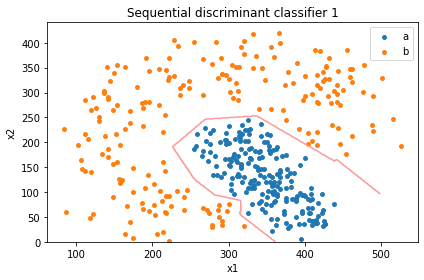

In [18]:
# Learn 3 sequential classifiers, results will be different each time
G = learn_sequential_classifier(a, b, max_iter=None)
y_pred = sequential_classifier(grid, G)
zz = np.array(y_pred).reshape(xx.shape)
plt.contour(xx, yy, zz, levels=list(range(4)), cmap='Paired')

plt.scatter(a[:, 0], a[:, 1], c='C0', label='a', s=15)
plt.scatter(b[:, 0], b[:, 1], c='C1', label='b', s=15)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Sequential discriminant classifier 1')
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# Error analysis
classifier_errors = {}
for j in [1, 2, 3, 4, 5]:
    for i in range(20):
        G = learn_sequential_classifier(a, b, max_iter=j)
        a_pred = sequential_classifier(a, G)
        b_pred = sequential_classifier(b, G)
        error_rate = (np.sum(a_pred != 1) + np.sum(b_pred != 2)) / (a.shape[0] + b.shape[0])
        classifier_errors.setdefault(j, []).append(error_rate)

In [14]:
stats = {}
for j, errors in classifier_errors.items():
    d = {}
    d['mean'] = np.mean(errors)
    d['std'] = np.std(errors)
    d['max'] = np.max(errors)
    d['min'] = np.min(errors)
    stats[j] = d
stats

{1: {'mean': 0.783125,
  'std': 0.04532435189828974,
  'max': 0.8625,
  'min': 0.715},
 2: {'mean': 0.63825, 'std': 0.03607370926311848, 'max': 0.695, 'min': 0.5825},
 3: {'mean': 0.53575, 'std': 0.10305975208586522, 'max': 0.62, 'min': 0.1025},
 4: {'mean': 0.45125000000000004,
  'std': 0.1350428172840007,
  'max': 0.565,
  'min': 0.1225},
 5: {'mean': 0.377125,
  'std': 0.17364164786997385,
  'max': 0.525,
  'min': 0.0775}}

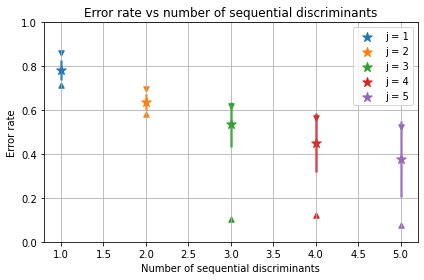

In [20]:
# Plot stats
for (j, stat), c in zip(stats.items(), ['C0', 'C1', 'C2', 'C3', 'C4']):
    plt.scatter(j, stat['mean'], c=c, marker='*', s=100, label=f'j = {j}')
    plt.scatter(j, stat['min'], c=c, marker='^', s=30)
    plt.scatter(j, stat['max'], c=c, marker='v', s=30)
    plt.vlines(j, stat['mean'] - stat['std'], stat['mean'] + stat['std'], color=c, lw=2.5, alpha=0.8)
plt.xlabel('Number of sequential discriminants')
plt.ylabel('Error rate')
plt.title('Error rate vs number of sequential discriminants')
plt.legend()
plt.grid()
plt.ylim(0, 1)
plt.tight_layout()
plt.show()